<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [119]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [120]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [121]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [122]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



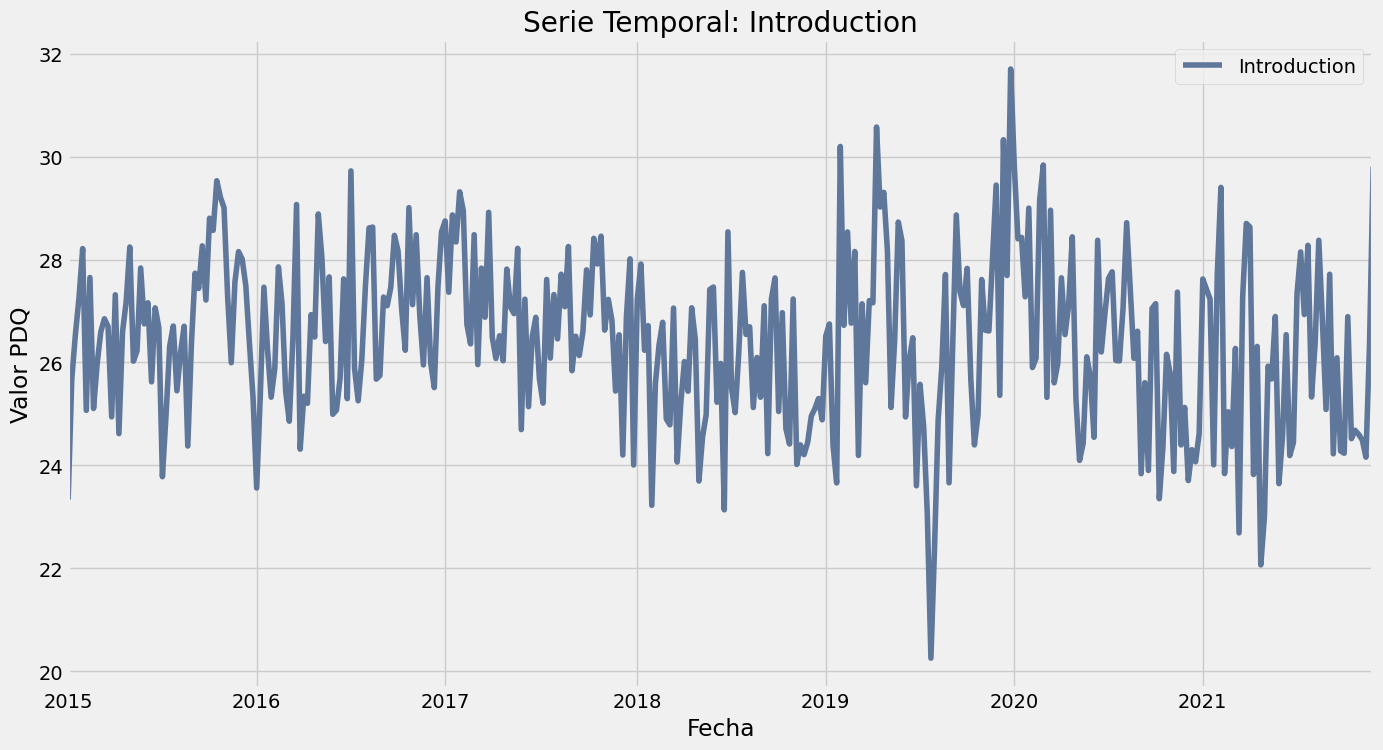

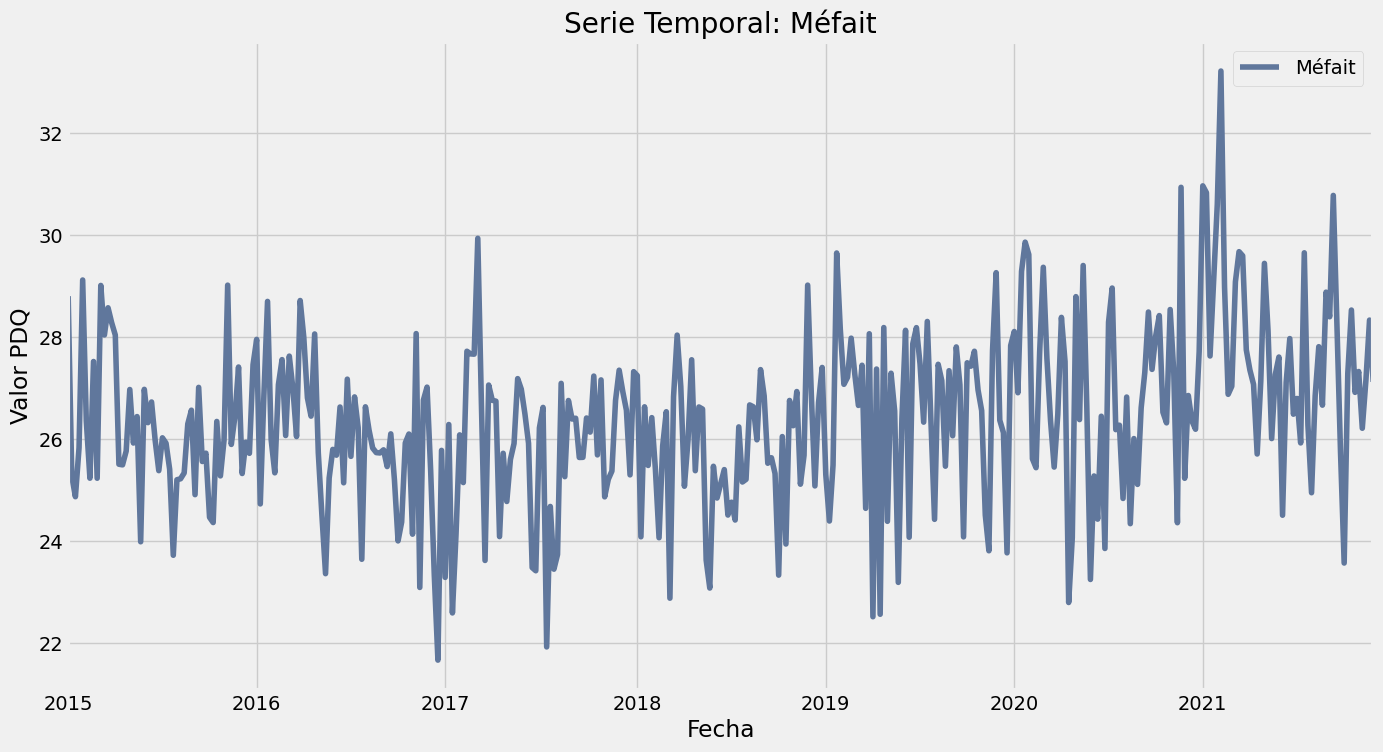

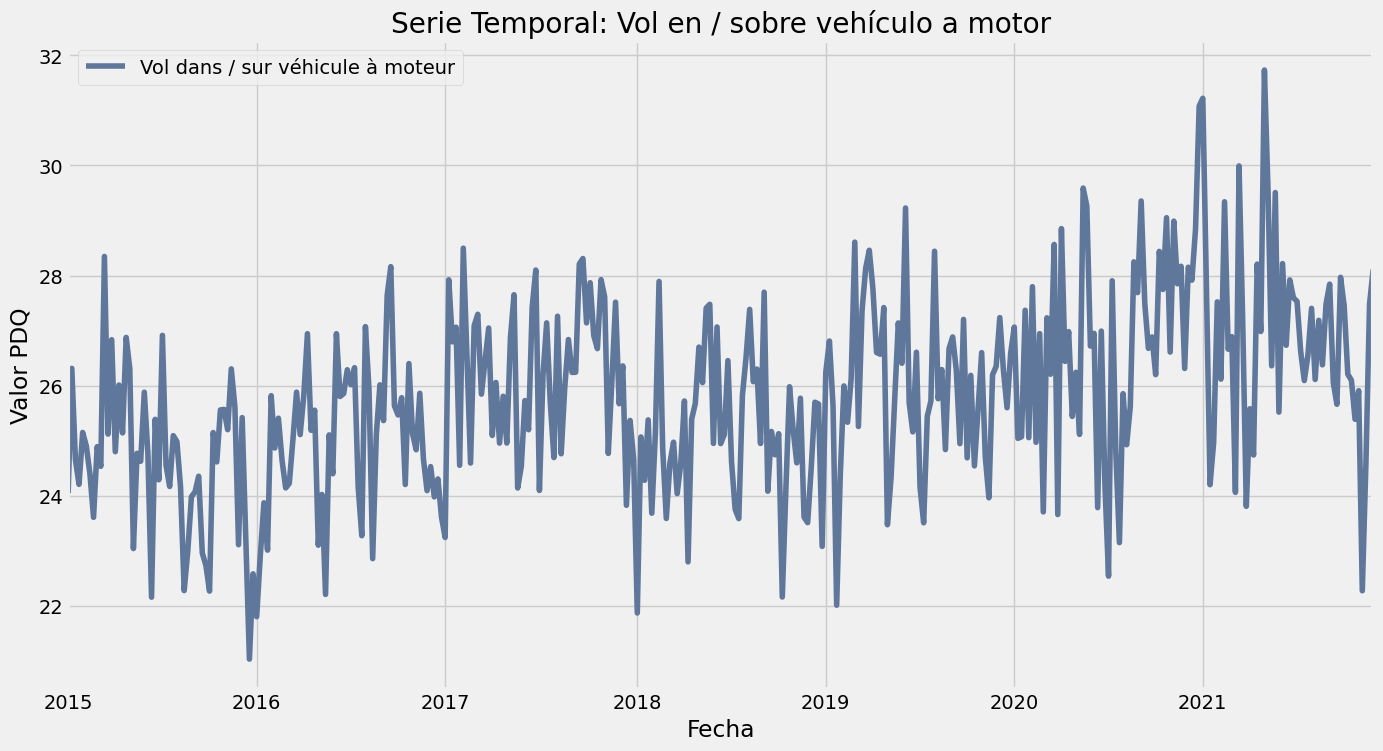

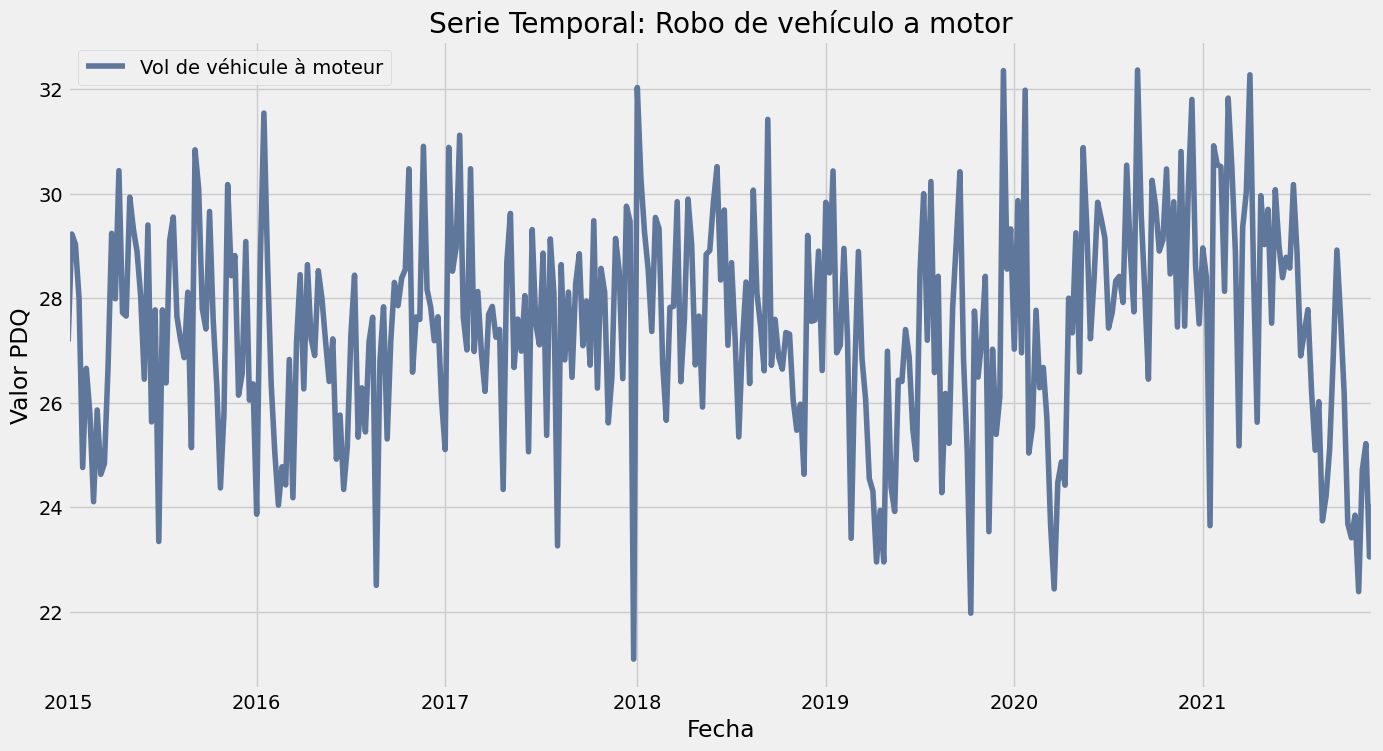

In [123]:
plt.figure(figsize=(15, 8))
y_s1['pdq'].plot(label='Introduction')
plt.title('Serie Temporal: Introduction')
plt.xlabel('Fecha')
plt.ylabel('Valor PDQ')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
y_s2['pdq'].plot(label='Méfait')
plt.title('Serie Temporal: Méfait')
plt.xlabel('Fecha')
plt.ylabel('Valor PDQ')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
y_s3['pdq'].plot(label='Vol dans / sur véhicule à moteur')
plt.title('Serie Temporal: Vol en / sobre vehículo a motor')
plt.xlabel('Fecha')
plt.ylabel('Valor PDQ')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
y_s4['pdq'].plot(label='Vol de véhicule à moteur')
plt.title('Serie Temporal: Robo de vehículo a motor')
plt.xlabel('Fecha')
plt.ylabel('Valor PDQ')
plt.legend()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



Rango de fechas: 2015-01-04 → 2021-11-28
Observaciones: 361
count    361.000000
mean      26.389151
std        1.677889
min       21.660870
25%       25.371134
50%       26.406250
75%       27.361538
max       33.220588
Name: pdq, dtype: float64


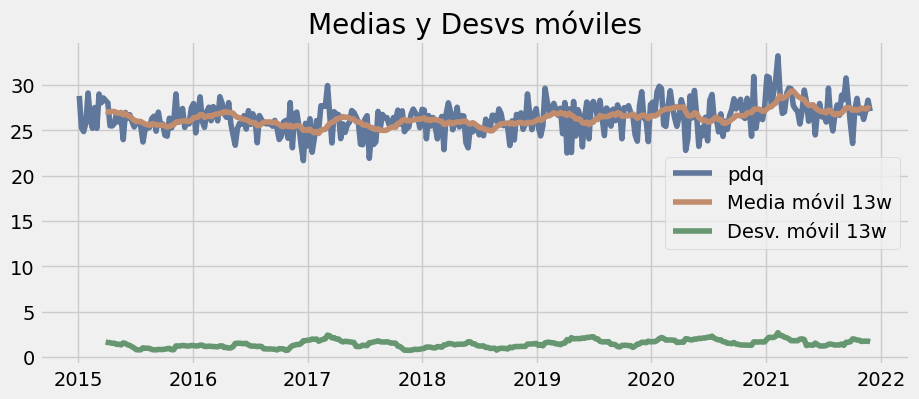

ADF: stat=-5.435, p-value=0.0000, usedlag=4, nobs=356
Umbrales: {'1%': np.float64(-3.448853029339765), '5%': np.float64(-2.869693115704379), '10%': np.float64(-2.571113512498422)}


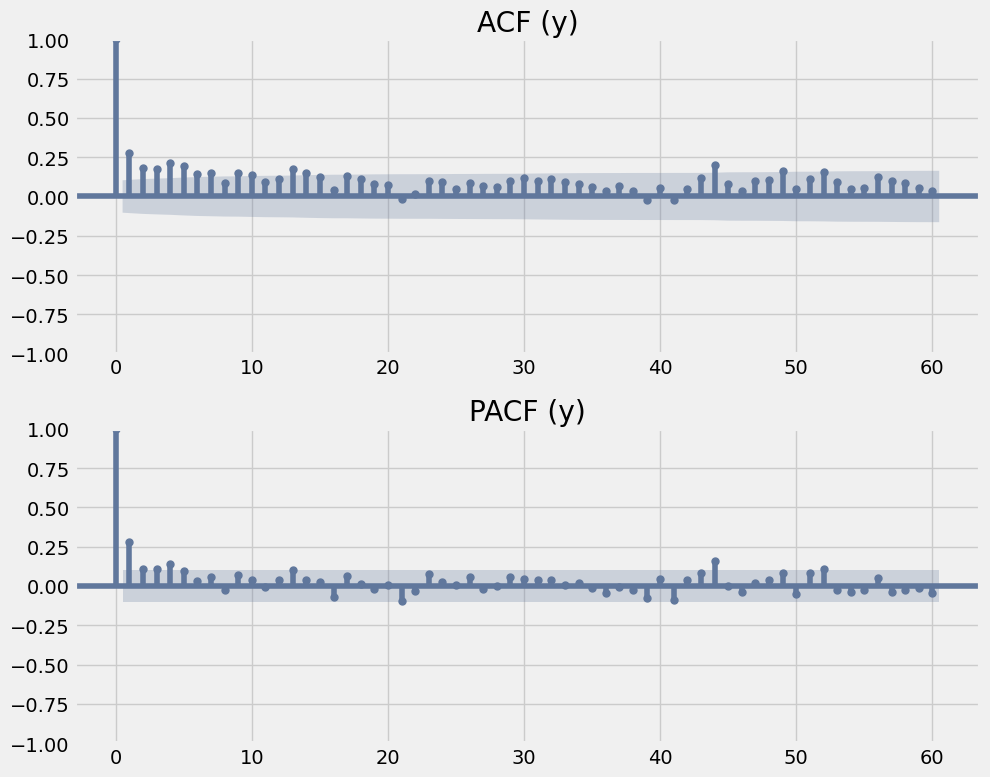

In [124]:
y = y_s2['pdq'].copy().sort_index()
y = y.asfreq('W')  # asegurar frecuencia semanal
y = y.dropna()

target_date = pd.to_datetime('2021-01-01')
S = 52  # estacionalidad anual en serie semanal

# ===== 1) EDA =====
print("Rango de fechas:", y.index.min().date(), "→", y.index.max().date())
print("Observaciones:", len(y))
print(y.describe())

# Medias / desvs móviles (tendencia/varianza)
roll_w = 13  # ~ trimestre (13 semanas)
rm = y.rolling(roll_w, min_periods=roll_w).mean()
rs = y.rolling(roll_w, min_periods=roll_w).std()

plt.figure(figsize=(10,4))
plt.plot(y.index, y.values, label="pdq")
plt.plot(rm.index, rm.values, label=f"Media móvil {roll_w}w")
plt.plot(rs.index, rs.values, label=f"Desv. móvil {roll_w}w")
plt.title("Medias y Desvs móviles")
plt.legend()
plt.show()

# ADF (estacionariedad)
adf_stat, pval, usedlag, nobs, crit, icbest = sm.tsa.stattools.adfuller(y.dropna(), autolag='AIC')
print(f"ADF: stat={adf_stat:.3f}, p-value={pval:.4f}, usedlag={usedlag}, nobs={nobs}")
print("Umbrales:", crit)

# ACF / PACF
fig, axes = plt.subplots(2, 1, figsize=(10,8))
sm.graphics.tsa.plot_acf(y.dropna(), lags=60, ax=axes[0])
axes[0].set_title("ACF (y)")
sm.graphics.tsa.plot_pacf(y.dropna(), lags=60, ax=axes[1], method='ywm')
axes[1].set_title("PACF (y)")
plt.tight_layout()
plt.show()

In [125]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Top 10 por AIC:
       order         sorder          aic          bic
0  (1, 0, 1)  (0, 1, 1, 12)  1092.673950  1107.311878
1  (1, 0, 1)  (1, 1, 1, 12)  1094.279424  1112.576835
2  (1, 1, 1)  (0, 1, 1, 12)  1094.853873  1109.477840
3  (0, 1, 1)  (0, 1, 1, 12)  1094.937335  1105.905310
4  (1, 1, 1)  (1, 1, 1, 12)  1097.973117  1116.253076
5  (0, 1, 1)  (1, 1, 1, 12)  1098.025410  1112.649377
6  (0, 0, 1)  (0, 1, 1, 12)  1099.956320  1110.934767
7  (1, 1, 1)  (0, 0, 1, 12)  1101.132464  1115.920838
8  (1, 0, 0)  (0, 1, 1, 12)  1101.296576  1112.285457
9  (0, 1, 1)  (0, 0, 1, 12)  1101.320735  1112.412015

Mejor modelo según AIC:
SARIMA (1, 0, 1) x (0, 1, 1, 12)

Métricas en Test:
MAE  = 1.887
RMSE = 2.416
MAPE = 0.07%


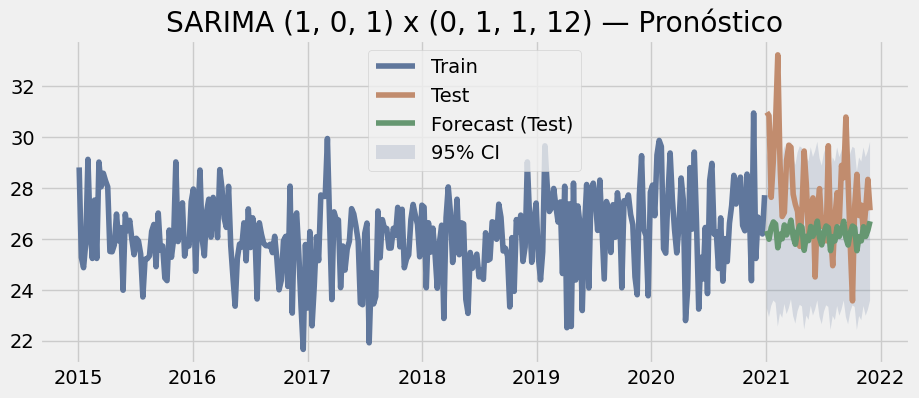

In [126]:
results = []
y = y_s2.copy().sort_index()
y = y.asfreq('W')
y = y.dropna(subset=['pdq'])

for order, sorder in params:
    try:
        runner = SarimaModels((order, sorder))
        model_fit = runner.fit_model(y, target_date)

        aic = model_fit.aic
        bic = model_fit.bic
        converged = bool(model_fit.mle_retvals.get('converged', False))

        if not converged:
            continue  # descartar modelos no convergentes

        results.append({
            "order": order,
            "sorder": sorder,
            "aic": aic,
            "bic": bic
        })

    except Exception:
        # saltar modelos que fallen
        pass

# ========= Top 10 por AIC ==========
res_df = pd.DataFrame(results).sort_values(["aic","bic"]).reset_index(drop=True)
print("Top 10 por AIC:")
print(res_df.head(10))

best_order = tuple(res_df.loc[0, "order"])
best_sorder = tuple(res_df.loc[0, "sorder"])
print("\nMejor modelo según AIC:")
print("SARIMA", best_order, "x", best_sorder)

# ========= Ajustar modelo final en train y pronosticar en test ==========
best_runner = SarimaModels((best_order, best_sorder))
best_fit = best_runner.fit_model(y, target_date)

# pronóstico
y_train, y_test = best_runner.test_train_model(y, target_date)
fc = best_fit.get_forecast(steps=len(y_test))
pred_mean = pd.Series(fc.predicted_mean, index=y_test.index)
pred_ci = fc.conf_int(alpha=0.05)
pred_ci.index = y_test.index

# métricas
Mae  = mae(y_test["pdq"], pred_mean)
Rmse = rmse(y_test["pdq"], pred_mean)
Mape = mape(y_test["pdq"], pred_mean)

print(f"\nMétricas en Test:")
print(f"MAE  = {Mae:.3f}")
print(f"RMSE = {Rmse:.3f}")
print(f"MAPE = {Mape:.2f}%")

# ========= Gráfico ==========
plt.figure(figsize=(10,4))
plt.plot(y_train.index, y_train['pdq'], label="Train")
plt.plot(y_test.index,  y_test['pdq'],  label="Test")
plt.plot(pred_mean.index, pred_mean, label="Forecast (Test)")
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], alpha=0.2, label="95% CI")
plt.title(f"SARIMA {best_order} x {best_sorder} — Pronóstico")
plt.legend()
plt.show()


El mejor modelo según AIC:
SARIMA (1, 0, 1) x (0, 1, 1, 12) con un valor 1092.673950

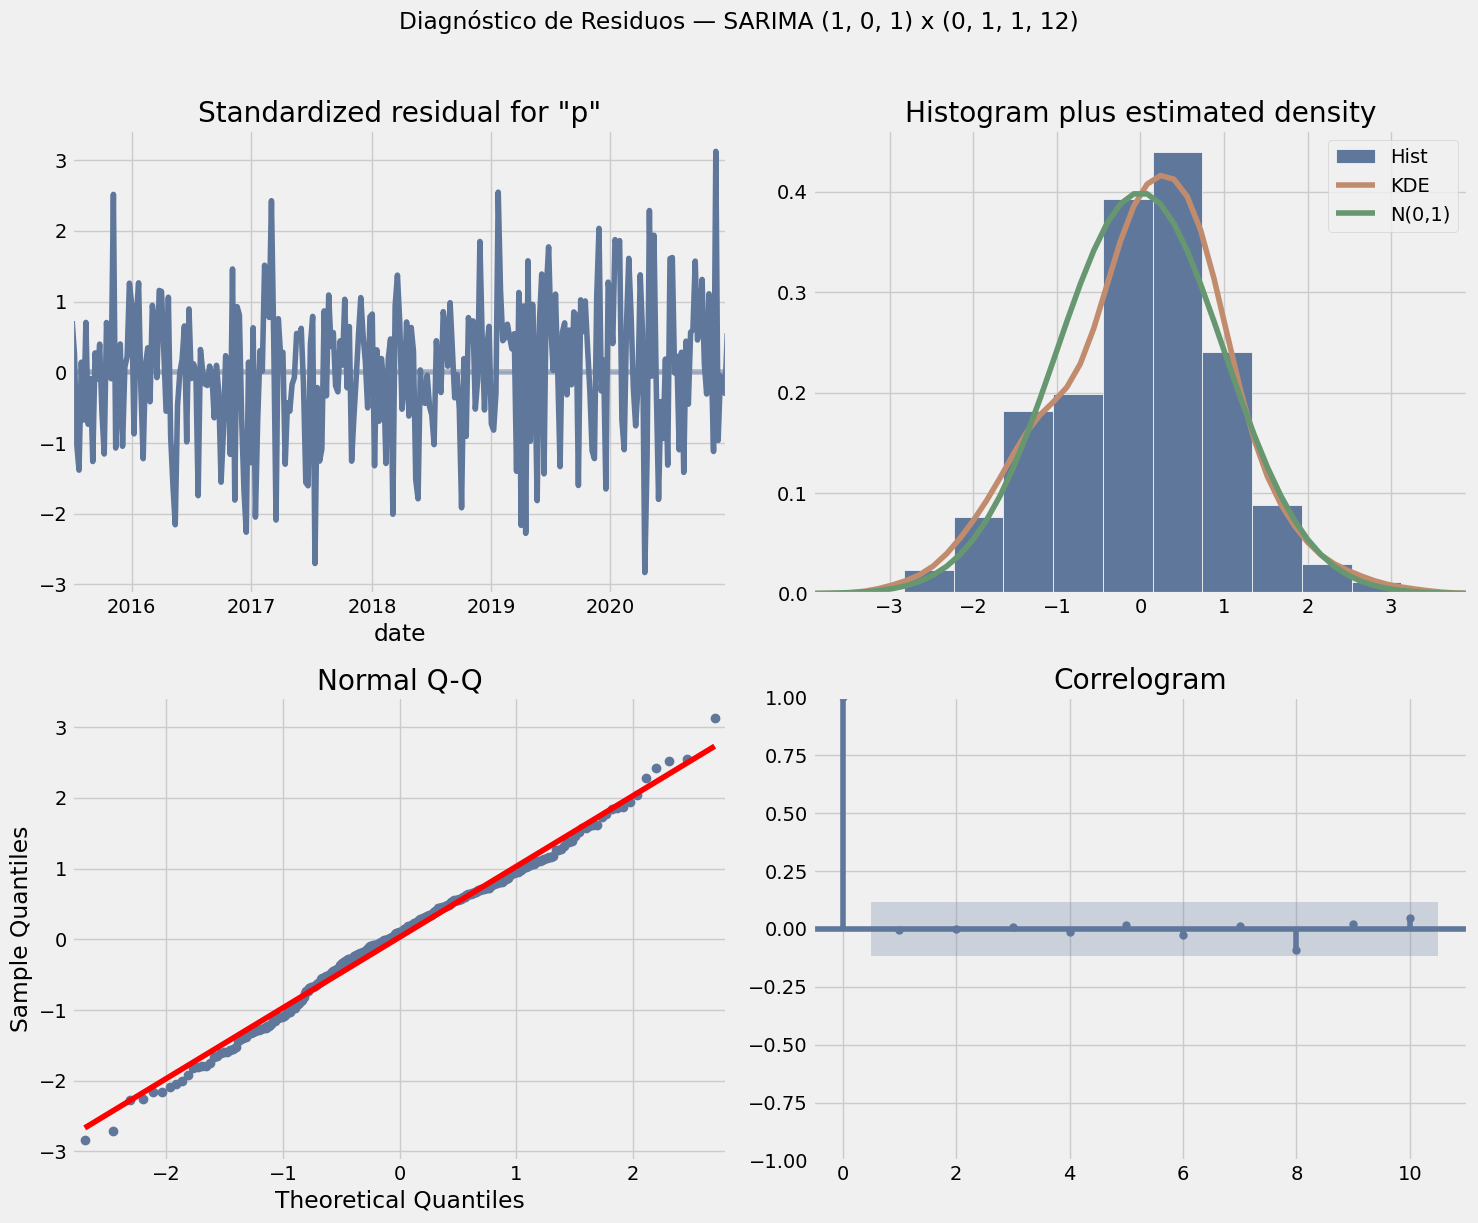


Gráfico de diagnóstico guardado como 'best_model_residuals.png'

Ljung–Box test (H0: residuos ∼ ruido blanco):
       lb_stat     lb_pvalue
12  101.422135  2.930124e-16
24  108.205560  1.158797e-12
36  109.985982  2.027045e-09
52  115.637523  9.717934e-07


In [132]:
import statsmodels.api as sm

# residuos
resid = best_fit.resid.dropna()

# gráficos de diagnóstico
fig = best_fit.plot_diagnostics(figsize=(15,12))
plt.suptitle(f"Diagnóstico de Residuos — SARIMA {best_order} x {best_sorder}", y=1.02)
plt.tight_layout()
plt.savefig('best_model_residuals.png')
plt.show()

print("\nGráfico de diagnóstico guardado como 'best_model_residuals.png'")

# Test de Ljung–Box
lb = sm.stats.acorr_ljungbox(resid, lags=[12,24,36,52], return_df=True)
print("\nLjung–Box test (H0: residuos ∼ ruido blanco):")
print(lb)

Los resultados del test de Ljung–Box indican que los residuos no se comportan como ruido blanco, ya que los p valores son muchos.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [127]:
from prophet import Prophet

In [133]:
prophet_df = y_s2['pdq'].reset_index()
prophet_df.columns = ['ds', 'y']

print("Encabezado del DataFrame de Prophet:")
print(prophet_df.head())
print("\nInformación del DataFrame de Prophet:")
prophet_df.info()

Encabezado del DataFrame de Prophet:
          ds          y
0 2015-01-04  28.803030
1 2015-01-11  25.270073
2 2015-01-18  24.867257
3 2015-01-25  25.828571
4 2015-02-01  29.120000

Información del DataFrame de Prophet:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      361 non-null    datetime64[ns]
 1   y       361 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [134]:
target_date = pd.to_datetime('2021-01-01')

prophet_train_df = prophet_df[prophet_df['ds'] < target_date]
prophet_test_df = prophet_df[prophet_df['ds'] >= target_date]

print("Encabezado del DataFrame de entrenamiento de Prophet:")
print(prophet_train_df.head())
print("\nEncabezado del DataFrame de prueba de Prophet:")
print(prophet_test_df.head())

m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False)

m.fit(prophet_train_df)
future = m.make_future_dataframe(periods=len(prophet_test_df), freq='W')
forecast = m.predict(future)

prophet_preds = forecast[['ds', 'yhat']].set_index('ds')
df_prophet_preds = prophet_test_df.set_index('ds').join(prophet_preds)

print("\nEncabezado del DataFrame de predicciones de Prophet:")
print(df_prophet_preds.head())

Encabezado del DataFrame de entrenamiento de Prophet:
          ds          y
0 2015-01-04  28.803030
1 2015-01-11  25.270073
2 2015-01-18  24.867257
3 2015-01-25  25.828571
4 2015-02-01  29.120000

Encabezado del DataFrame de prueba de Prophet:
            ds          y
313 2021-01-03  30.967742
314 2021-01-10  30.833333
315 2021-01-17  27.629032
316 2021-01-24  29.114754
317 2021-01-31  30.606061

Encabezado del DataFrame de predicciones de Prophet:
                    y       yhat
ds                              
2021-01-03  30.967742  27.067514
2021-01-10  30.833333  27.344020
2021-01-17  27.629032  27.399456
2021-01-24  29.114754  27.394616
2021-01-31  30.606061  27.516572


In [135]:
metrics_prophet = summary_metrics(df_prophet_preds)
metrics_prophet['model'] = 'Prophet'
print("Métricas del Modelo Prophet:")
print(metrics_prophet)

Métricas del Modelo Prophet:
      mae     mse   rmse    mape   maape   wmape   mmape   smape    model
0  1.2714  2.9482  1.717  0.0446  0.0445  0.0458  0.0431  0.0456  Prophet


In [137]:
combined_metrics = pd.concat([metrics_best_sarima, metrics_prophet], ignore_index=True)
print("Métricas Combinadas del Modelo:")
print(combined_metrics)

Métricas Combinadas del Modelo:
      mae     mse    rmse    mape   maape   wmape   mmape   smape  \
0  1.8866  5.8358  2.4157  0.0656  0.0653  0.0680  0.0634  0.0686   
1  1.2714  2.9482  1.7170  0.0446  0.0445  0.0458  0.0431  0.0456   

                       model  
0  SARIMA_(1,0,1)X(0,1,1,12)  
1                    Prophet  


En el análisis comparativo entre los modelos SARIMA y Prophet, los resultados muestran que Prophet obtuvo un mejor desempeño. El modelo SARIMA presentó un MAE de 1.8866, un RMSE de 2.4157 y un MAPE de 0.0656, mientras que Prophet logró menores errores: MAE de 1.2714, RMSE de 1.7170 y MAPE de 0.0446. Esto indica que las predicciones de Prophet estuvieron más cercanas a los valores reales y con menor variabilidad.

Las diferencias entre ambos modelos explican este comportamiento. SARIMA requiere que la serie sea estacionaria o que pueda transformarse para serlo, y su construcción demanda seleccionar manualmente los parámetros p, d, q y P, D, Q, S. Además, su ajuste suele involucrar análisis de autocorrelación y diagnóstico de residuos. En contraste, Prophet descompone la serie en componentes de tendencia, estacionalidad y efectos especiales, maneja bien datos faltantes u outliers y automatiza gran parte del proceso de ajuste, lo que facilita su uso.

En esta serie temporal, Prophet ofreció mejores resultados porque modela estacionalidades complejas de forma flexible, se adapta a cambios en la tendencia y es más robusto frente a datos ruidosos. Por eso, cuando se requiere un pronóstico preciso con poco esfuerzo de ajuste, Prophet resulta conveniente. SARIMA sigue siendo preferible cuando se necesita un análisis estadístico riguroso, con interpretabilidad de los componentes AR y MA y con datos limpios.


Conclusiones:
Prophet puede ser preferible a SARIMA cuando se necesita un modelo fácil de implementar y que funcione bien sin un proceso complejo de ajuste manual. Es especialmente útil cuando la serie tiene estacionalidades marcadas, datos faltantes, outliers o cambios en la tendencia, ya que Prophet está diseñado para manejar estas situaciones de manera automática. También es una buena opción cuando se requiere obtener resultados rápidos sin ser experto en series de tiempo.
En conclusión, aunque SARIMA es un modelo poderoso, para esta serie el modelo Prophet entregó un pronóstico más preciso y con menor error, por lo que se convierte en la opción más adecuada en este caso.